In [1]:
import os
import subprocess as sp
import xarray as xr
import matplotlib.pyplot as plt


In [2]:
'''
Python script to plot OH number density (10^5 cm-3) for UKESM1.3 evaluation.

It assumes the model output to be converted to netCDF:
<in_ohndts>/<expid>/<stashitem>/<stashitem>_2004-2014.nc

It uses the following STASH items:
34081: OH MASS MIXING RATIO AFTER TIMESTEP
50062: TROPOSPHERIC MASK (if l_trop=True)
50063: AIR MASS DIAGNOSTIC (WHOLE ATMOS)
50255: grid volume (constant)

The calculation is based on the script for creating Figure 3 of 
Folberth et al., 2021 (https://doi.org/10.5281/zenodo.6553281),
but currently only for airmass weighted OH number density.
'''

'\nPython script to plot OH number density (10^5 cm-3) for UKESM1.3 evaluation.\n\nIt assumes the model output to be converted to netCDF:\n<in_ohndts>/<expid>/<stashitem>/<stashitem>_2004-2014.nc\n\nIt uses the following STASH items:\n34081: OH MASS MIXING RATIO AFTER TIMESTEP\n50062: TROPOSPHERIC MASK (if l_trop=True)\n50063: AIR MASS DIAGNOSTIC (WHOLE ATMOS)\n50255: grid volume (constant)\n\nThe calculation is based on the script for creating Figure 3 of \nFolberth et al., 2021 (https://doi.org/10.5281/zenodo.6553281),\nbut currently only for airmass weighted OH number density.\n'

In [3]:
# ==============================================================================
def dict_com_chem_pars():
    # define dictionary of common parameters
    common_parameters = {}
    common_parameters['mm_air'] = 28.9647E-03 # kg/mol
    common_parameters['mm_ch4'] = 16.04E-03 # kg/mol
    common_parameters['mm_oh'] = 17.04E-03 # kg/mol
    common_parameters['mm_o3'] = 48.04E-03 # kg/mol
    common_parameters['molecsinmol'] = 6.022E23 # molecules/mol
    common_parameters['molspmolecs'] = 1.0/6.022E23 # mol/molecules
    common_parameters['kg2tg'] = 1.0E-09
    common_parameters['kg2pg'] = 1.0E-12
    common_parameters['mr2ppm'] = 1.0E+06
    common_parameters['ppm2mr'] = 1.0/1.0E+06
    common_parameters['mr2ppb'] = 1.0E+09
    common_parameters['ppb2mr'] = 1.0/1.0E+09
    common_parameters['mmr2ppt'] = 1.0E+12
    common_parameters['ppt2mmr'] = 1.0/1.0E+12
    common_parameters['secindy'] = (3600.0 * 24.0)
    common_parameters['secinmn'] = (3600.0 * 24.0 * 30.0)
    common_parameters['secinyr'] = (3600.0 * 24.0 * 30.0 * 12.0)
    common_parameters['qm2qcm'] = 1.0E-06 # m^3 --> cm^3
    return common_parameters

In [4]:
# =============================================================================
def check_dir_exists(location):
    errcode = 0
    isdir = os.path.isdir(location)
    if not isdir:
        print('directory:')
        print('>> '+location+' <<')
        print('does not exist; stopping now.')
        errcode = 1
        return errcode
    else:
        errcode = 0
        return errcode

# ==============================================================================
def check_file_exists(file):
    errcode = 0
    isfile_chk = os.path.isfile(file)
    if not isfile_chk:
        print('file:')
        print('>>'+file+'<<')
        print('not found!')
        errcode = 1
        return errcode
    else:
        errcode = 0
        return errcode

# ==============================================================================
def check_dir_create(location):
    isdir = os.path.isdir(location)
    if not isdir:
        print('directory:')
        print('>> '+location+' <<')
        print('does not exist; creating directory.')
        cp = sp.run(['mkdir', '-p', location])


Starting...

...working on experiment >>dr061<<
...working on experiment >>dr226<<
...working on experiment >>dr240<<
...working on experiment >>dr292<<


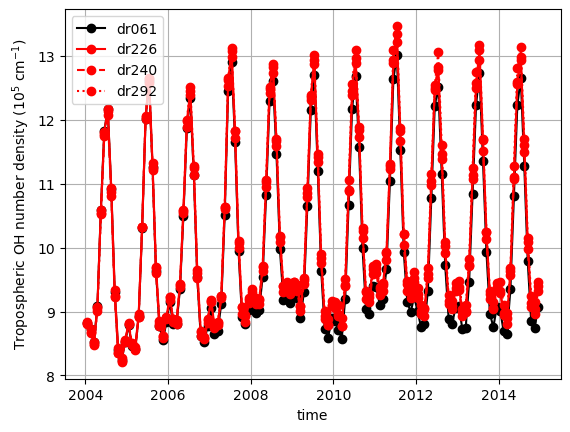

In [5]:
# ==========================================================================
# set control switches
l_prd_ohnd = True # whether to produce global annual mean OH number densities
l_trop     = True # whether to calculate tropospheric ot whole-atmosphere OH (l_trop = True for tropospheric)

l_annual_mean = True # True for annual mean, False for monthly mean
# ==========================================================================
# define dictionary of common parameters
chem_pars = dict_com_chem_pars() # dictionary of chemistry parameters

# ==========================================================================
# define data locations
in_ohndts   = '/gws/nopw/j04/ukca_vol2/lstecher/UKESM1.3_evaluation/model_output/'
out_plots   = '/gws/nopw/j04/ukca_vol2/lstecher/UKESM1.3_evaluation/plots/'
file_volume = '/gws/nopw/j04/ukca_vol2/lstecher/UKESM1.3_evaluation/model_output/gb_volume_notime.nc'
# ==========================================================================
# define list of experiments to process
expids = ['dr061', 'dr226', 'dr240', 'dr292']
colors = ['k', 'r', 'r', 'r']
linestyles = ['solid', 'solid', 'dashed', 'dotted']

## STASH items
oh_stash       = '34081'
airmass_stash  = '50063'
tropmask_stash = '50062'
# ==========================================================================
# clear_screen()
cp=sp.run('clear', shell=True)
print()
print('Starting...')
print()

# ==========================================================================
# produce airmass weighted OH number densities (10^5 cm-3)
if l_prd_ohnd:
    fig = plt.figure()
    for i, item in enumerate(expids):
        # ==============================================================
        # produce 3D airmass weighted OH number density (10^5 cm-3)
        print(f'...working on experiment >>{item:<5s}<<')

        ### Read in OH, airmass, grid volume, troposphere mask
        in_dir = os.path.join(in_ohndts, 'u-'+item)

        in_fle = os.path.join(in_dir, oh_stash, oh_stash+'_2004-2014.nc')
        errcd = check_file_exists(in_fle)
        ds_OH = xr.open_dataset(in_fle)

        in_aux1 = os.path.join(in_dir, airmass_stash, airmass_stash+'_2004-2014.nc')
        errcd = check_file_exists(in_aux1)
        ds_aux1 = xr.open_dataset(in_aux1)
        airmass = ds_aux1.UM_m01s50i063_vn1308

        in_aux2 = os.path.join(file_volume)
        errcd = check_file_exists(in_aux2)
        ds_aux2 = xr.open_dataset(in_aux2)

        if l_trop:
            in_tropmask = os.path.join(in_dir, tropmask_stash, tropmask_stash+'_2004-2014.nc')
            errcd = check_file_exists(in_tropmask)
            ds_tropmask = xr.open_dataset(in_tropmask)
            trop_mask = ds_tropmask.UM_m01s50i062_vn1308
    
            # mask all values less then 0.01 in tropo-mask
            trop_mask_binary = xr.where(trop_mask >= 0.01, 1.0, 0.0)

        ## OH mass fraction * air mass
        tmp1 = ds_OH.UM_m01s34i081_vn1308 * airmass
        
        ## OH molecule number: 1/OH_molar_mass (mol/kg) * Na (1/mol) * 1.0E-06 # m^3 --> cm^3 
        tmp2 = tmp1 * (1.0/chem_pars['mm_oh']) * chem_pars['molecsinmol'] * chem_pars['qm2qcm']
        
        volume = ds_aux2.UM_m01s50i255_vn1105
        ## remove time dimension for constant volume
        volume = volume.squeeze("time")
        
        ## align atmosphere_hybrid_height_coordinate (not exactly the same due to rounding issues, volume from different model version)
        tmp2, volume = xr.align(tmp2, volume, join='override', exclude=("time", "latitude", "longitude"))
        ## broadcast constant volume to 4D
        volume_bc, tmp2_bc = xr.broadcast(volume, tmp2)
        
        ## OH number density (cm-3)
        OH_nd = tmp2_bc / volume_bc

        if l_trop:
            ### calculate tropospheric sum
            numerator = (OH_nd * airmass * trop_mask_binary).sum("atmosphere_hybrid_height_coordinate")
            denominator = (airmass * trop_mask_binary).sum("atmosphere_hybrid_height_coordinate")
            OH_airmass_weighted = numerator / denominator * 1.0e-05
        else:
            ### calculate whole atmosphere sum
            numerator = (OH_nd * airmass).sum("atmosphere_hybrid_height_coordinate")
            denominator = (airmass).sum("atmosphere_hybrid_height_coordinate")
            OH_airmass_weighted = numerator / denominator * 1.0e-05

        ### plotting
        OH_airmass_weighted_global = OH_airmass_weighted.mean(("latitude", "longitude"))

        if l_annual_mean:
            ### plot annual mean
            OH_airmass_weighted_global.groupby("time.year").mean().plot(marker='o', 
                                                                        label=item, 
                                                                        color=colors[i], 
                                                                        linestyle=linestyles[i])
        else: 
            ### plot monthly mean
            OH_airmass_weighted_global.plot(marker='o', 
                                            label=item, 
                                            color=colors[i], 
                                            linestyle=linestyles[i])

    if l_trop:
        plt.ylabel('Tropospheric OH number density (10$^5$ cm$^{-1}$)')
    else:
        plt.ylabel('Whole-atmosphere OH number density (10$^5$ cm$^{-1}$)')
    
    plt.grid()
    plt.legend()
    #plt.show()
    plt.savefig(out_plots+'/OH_number_density.png', format='png')